In [1]:
using OrdinaryDiffEq
using FFTW
using LinearAlgebra
using Plots
using BenchmarkTools

include("../../code/TaylorFourier.jl")
include("NLS_ODE_DP5_fcns.jl")
include("NLS_ODE_TF_fcns.jl")

NLS_ODE_TF_cache_init (generic function with 1 method)

## Numerical solution of cubic NLS with Taylor-Fourier series

### Numerical solution with a Lawson method based on a 5th order explicit RK method (due to Dormand and Prince)

In [27]:
J = 2^6
J2 = 2J
W0=Vector{ComplexF64}(undef,J2)
W0[1]= zero(ComplexF64)
xx = range(0,stop=2pi,length=J2)
omega = 1.
p = NLS_ODE_cache_init(W0)
tol_1 =5e-8 



function DP5err(epsilon)
    
    t_end = pi/10/epsilon^2
    theta = omega*t_end
    tspan = (0.,t_end)
    W0=Vector{ComplexF64}(undef,J2)
    W0[1]= zero(ComplexF64)
    for i in 2:J
        W0[i]=-epsilon+0.0im
    end
    W0[J+1]= zero(ComplexF64)
    for i in J+2:J2
        W0[i]=epsilon+0.0im
    end
    #=
    for i in 1:2J
        W0[i]= epsilon*sin(xx[i])
    end
    for i in 2:J
    W0[i]=epsilon*xx[i]/pi+0.0im
    end
    W0[J+1]= zero(ComplexF64)
    for i in J+1:J2
        W0[i]=epsilon*(2pi-xx[i])/pi+0.0im
    end
    =#
    yrange=(-2epsilon,2epsilon)
    
    errU = similar(W0)

    prob = ODEProblem(NLS_ODE!,W0,tspan,p)

    @time solDP5 = solve(prob,DP5(),adaptive=false,dt=t_end/64000,save_everystep=true)  
    tt = solDP5.t
    solDP5_2 = solve(prob,DP5(),adaptive=false,dt=t_end/256000,saveat=tt,maxiters=10000000)
    WW = solDP5.u
    WW_2 = solDP5_2.u
    UU = [expA(W,theta,p) for W in WW] 
    UU_2 = [expA(W,theta,p) for W in WW_2] 
    errUU = UU - UU_2
    for j in eachindex(W0)
        errU[j] = maximum([abs(errUU[i][j]) for i in eachindex(tt)])
    end
    return errU
end


DP5err (generic function with 1 method)

  2.805255 seconds (384.08 k allocations: 673.602 MiB)
6.85606249933812e-13
  2.925799 seconds (384.08 k allocations: 673.602 MiB)
3.5960796408303987e-13
  3.605504 seconds (384.08 k allocations: 673.602 MiB, 17.01% gc time)
2.9304104801876585e-12
  3.292414 seconds (384.08 k allocations: 673.602 MiB, 11.60% gc time)
3.637027589667883e-6


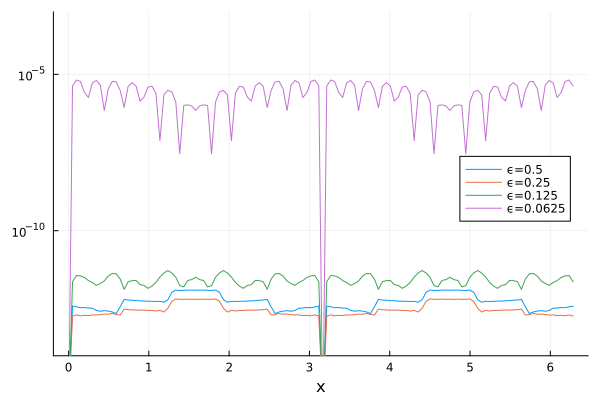

In [28]:
errrange = (1e-14,1e-3)
epsilon = 0.5
errU = DP5err(epsilon)
t_end = pi/10/epsilon^2
println(norm(errU)/sqrt(2J))

pl_err = plot(yscale=:log10, ylims = errrange, xlabel="x",
                legend=:right)

plot!(xx,abs.(errU),label="ϵ=$epsilon")

for j in 1:3
    epsilon /= 2
    errU = DP5err(epsilon)
    println(norm(errU)/sqrt(2J))

    plot!(xx,abs.(errU),label="ϵ=$epsilon")
end
display(pl_err)    

## Numerical solution with Taylor-Fourier

In [29]:

function TFerr(epsilon)
    
    t_end = pi/10/epsilon^2
    theta = omega*t_end
    tspan = (0.,t_end)
    yrange=(-2epsilon,2epsilon)
    W0=Vector{ComplexF64}(undef,J2)
    W0[1]= zero(ComplexF64)
    for i in 2:J
        W0[i]=-epsilon+0.0im
    end
    W0[J+1]= zero(ComplexF64)
    for i in J+2:J2
        W0[i]=epsilon+0.0im
    end
    xx = range(0,stop=2pi,length=J2+1)[1:end-1]
    #=
    for i in 1:2J
        W0[i]= epsilon*sin(xx[i])
    end
    for i in 2:J
    W0[i]=epsilon*xx[i]/pi+0.0im
    end
    W0[J+1]= zero(ComplexF64)
    for i in J+1:J2
        W0[i]=epsilon*(2pi-xx[i])/pi+0.0im
    end
    =#
    deg = 7
    M = 32J
    
    tf_cache = NLS_ODE_TF_cache_init(W0,omega,deg,M)

    prob_TF = PeriodicODEProblem(NLS_ODE_TF!, tf_cache, W0, omega)

    @time sol_TF = TaylorFourierSolve(prob_TF,deg,M);  

        
    tf_cache_2 = NLS_ODE_TF_cache_init(W0,omega,2+deg,2M)

    prob_TF_2 = PeriodicODEProblem(NLS_ODE_TF!, tf_cache_2, W0, omega)

    sol_TF_2 = TaylorFourierSolve(prob_TF_2,2+deg,2M)
    
    W_TF = sol_TF(t_end)
    U_TF = expA(W_TF,theta,p)
    
    W_TF_2 = sol_TF_2(t_end)
    U_TF_2 = expA(W_TF_2,theta,p)
    errU = U_TF - U_TF_2 .+ eps()

    return errU
end

TFerr (generic function with 1 method)

  3.253795 seconds (385 allocations: 760.032 MiB)
0.00015158629999212462
  4.228031 seconds (385 allocations: 760.032 MiB)
6.871779642873877e-5
  3.978846 seconds (385 allocations: 760.032 MiB)
3.420798083440072e-5
  3.059739 seconds (385 allocations: 760.032 MiB)
1.710306164233404e-5


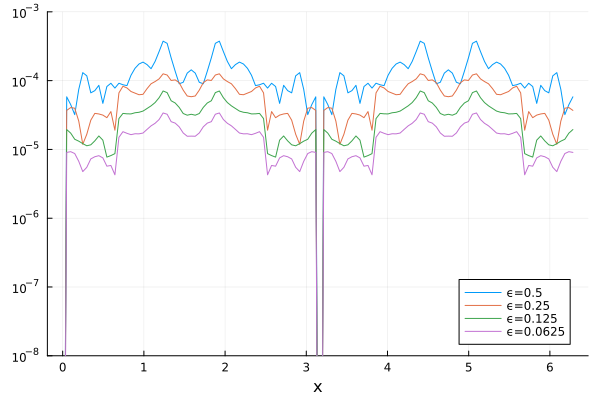

In [32]:
errrange = (1e-8,1e-3)
epsilon = 0.5
errU = TFerr(epsilon)
println(norm(errU)/sqrt(2J))

pl_err = plot(yscale=:log10, ylims = errrange, xlabel="x",
                legend=:bottomright)

plot!(xx,abs.(errU),label="ϵ=$epsilon")

for j in 1:3
    epsilon /= 2
    errU = TFerr(epsilon)
    println(norm(errU)/sqrt(2J))

    plot!(xx,abs.(errU),label="ϵ=$epsilon")
end
display(pl_err)    

In [33]:
savefig("error_versus_epsilon.pdf")

"/Users/andermurua/Dropbox/nereak/TaylorFFT/TaylorFourier-julia/examples/NLS/error_versus_epsilon.pdf"